In [1]:
import pandas as pd
import tweepy
import csv
import json


ACCESS_TOKEN = ''
ACCESS_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET =''

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)


c = tweepy.Cursor(api.search, q='coronavirus', lang='en')

count=201
page_needed=int(count/15) + 3 
c.pages(page_needed)

id_tweets = []
date = []
full_text_tweet =[]
for tweet in c.items():
    try:
        tweet = api.get_status(tweet.id, count=200, tweet_mode="extended")
        full_text_tweet.append(tweet.full_text)
        id_tweets.append(tweet.id)
    except:
        pass
    if len(full_text_tweet)==count: 
        break       
print("Total Data length", len(full_text_tweet))

Total Data length 201


In [2]:
tweets = pd.Series(full_text_tweet)

In [3]:
from sklearn.externals import joblib 
import string
import re
from keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd

Using TensorFlow backend.


In [4]:
LSTM = joblib.load('A_LSTM_MODEL3.pkl')
# loading
with open('ALSTM3_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
maxlen = 104


Instructions for updating:



In [5]:
happyemoticon = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
sademoticon = r" :'?[/|\(] "



def preprocess_text(sen):
    text =  remove_tags(sen)
    text = re.sub('['+ string.punctuation +']',' ',text) #remove punctuation
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) #Single character
    text = re.sub(r'\s+', ' ', text) #Removing multiple
    text = re.sub(r"([xX;:]-?[dD)]|:-?[\)]|[;:][pP])",happyemoticon,text)
    text = re.sub(r" :'?[/|\(] ",sademoticon,text)
    text = re.sub(r"(.)\1+", r"\1\1",text)
    text = re.sub(r"&\w+;", "",text)
    text = re.sub(r"https?://\S*", "",text)
    text = re.sub(r"https?://\S*", "",text)
    text = re.sub(r"&\w+;", "",text)
    
    return text

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)


In [6]:
filtered_text = []

for i in tweets:
    filtered_text.append(preprocess_text(str(i)))


In [7]:
pos_count=0
neg_count=0
neutral_count=0

In [8]:
sentiment = []
for i in range(len(filtered_text)):    
    example = filtered_text[i]
    instance = tokenizer.texts_to_sequences([example])
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)
    
    flat_list = [flat_list]
    text_predict = pad_sequences(flat_list, padding='post', maxlen=maxlen)
    
    predicted_score = LSTM.predict(text_predict)
    if predicted_score > 0.60:
        sentiment.append("😃")
        pos_count = pos_count+1

    elif predicted_score < 0.60 and predicted_score > 0.40:
        sentiment.append("😐")
        neutral_count=neutral_count+1

    else:
        sentiment.append("😔")
        neg_count = neg_count+1

In [9]:
sentiments = pd.Series(sentiment, name="Sentiment")
full_text_tweet = pd.Series(full_text_tweet, name="Tweet")        
result_dataframe = pd.concat([full_text_tweet, sentiments], axis=1)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

  import sys


In [10]:
result_dataframe

,Tweet,Sentiment
0,RT @puzzlesandgames: FOLLOW US and RETWEET this post for a chance to WIN THIS PUZZLE BOOK! We will #giveaway a puzzle book every day until…,😃
1,"RT @anniekarni: This came just days after Mulvaney said the media was hyping coronavirus, ""they think this will bring down the president, t…",😃
2,"RT @maddow: University of Washington IHME new forecast:\n\nOver 200,000 Americans dead from coronavirus by October 1:\n\nhttps://t.co/YdkMASF6UL",😐
3,Marketing in the middle of a global crisis | https://t.co/yCp1sVm5Im by Rirhandzu Shingwenyana via @Biz_Marketing #Covid19 #coronavirus #lockdown #pandemic #marketing,😃
4,"RT @draayyy09: Trump on coronavirus: ""If we stop testing right now, we'd have very few cases.\n\nI agree😂😂😂💔💔💔🤝🤝🤝",😃
5,RT @EffMktHype: Just to recap:\nCoronavirus 2nd wave potentially rolling in\nIndia and China skirmish with fatalities\nExplosive escalation at…,😃
6,RT @theharpoonman: Roberts joins liberals as Supreme Court rejects challenge to coronavirus limits on church services https://t.co/y8bcOdSA…,😃
7,RT @aubrey_huff: I will no longer wear a mask inside any business. It’s unconstitutional to enforce. Let’s make this bullshit stop now! Who…,😔
8,RT @kwelijournal: Sending condolences and light to Rep. Ilhan Omar and family. \n\nRep. Ilhan Omar's Father Dies Due to Coronavirus\n\nhttps://…,😔
9,RT @TheOnion: City Enters Phase 4 Of Pretending Coronavirus Over https://t.co/A5ZJbWnQP2 https://t.co/GUrredUKxL,😃


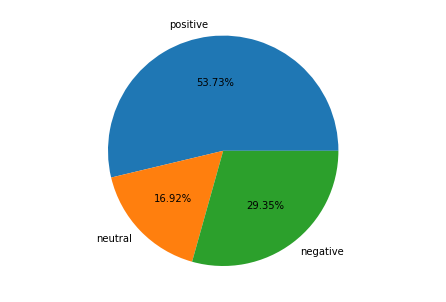

In [11]:
from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['positive', 'neutral', 'negative']
prediction = [pos_count,neutral_count,neg_count]
ax.pie(prediction, labels = langs,autopct='%1.2f%%')
plt.show()